In [ ]:
! pip install optuna

In [3]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
from sklearn.metrics import classification_report
import optuna
from optuna.samplers import TPESampler

In [4]:
df_train = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/train.csv')
df_test = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/test.csv')
df_clients = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/clients2.csv')
df_products = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/products.csv')

df_test_purch = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/test_purch/test_purch.csv', parse_dates=['transaction_datetime'])
df_train_purch = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/train_purch/train_purch.csv', parse_dates=['transaction_datetime'])

print('clients', df_clients.shape)
print('train', df_train.shape)
print('products', df_products.shape)
print('test', df_test.shape)
print('test_purch', df_test_purch.shape)
print('train_purch', df_train_purch.shape)

clients (200039, 6)
train (140027, 3)
products (43038, 11)
test (60012, 1)
test_purch (6883738, 13)
train_purch (15998952, 13)


### Предобработка. Сохранил предобработку.

In [21]:
df_features_train = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/df_features_train.csv')
df_features_test = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/df_features_test.csv')

In [3]:
# объединение дата фреймов
df_features_train = df_train.merge(df_clients, how='inner', on='client_id')
df_features_test = df_test.merge(df_clients, how='inner', on='client_id')

# подготовка дата фрейма для модели
df_features_train['first_issue_time'] = (pd.to_datetime(df_features_train['first_issue_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s') # перевел дату в формат unix
df_features_train['first_redeem_time'] = (pd.to_datetime(df_features_train['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features_train['first_redeem_delay'] = df_features_train['first_redeem_time'] - df_features_train['first_issue_time'] 
df_features_train = df_features_train.drop(['client_id.1', 'first_issue_date', 'first_redeem_date'], axis=1)

df_features_test['first_issue_time'] = (pd.to_datetime(df_features_test['first_issue_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s') # перевел дату в формат unix
df_features_test['first_redeem_time'] = (pd.to_datetime(df_features_test['first_redeem_date']) - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features_test['first_redeem_delay'] = df_features_test['first_redeem_time'] - df_features_test['first_issue_time'] 
df_features_test = df_features_test.drop(['client_id.1', 'first_issue_date', 'first_redeem_date'], axis=1)

#заполняю пропуски в дате
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_features_train.first_redeem_time = imputer.fit_transform(np.array(df_features_train.first_redeem_time).reshape(-1, 1))
df_features_train.first_redeem_delay = imputer.fit_transform(np.array(df_features_train.first_redeem_delay).reshape(-1, 1))

df_features_test.first_redeem_time = imputer.fit_transform(np.array(df_features_test.first_redeem_time).reshape(-1, 1))
df_features_test.first_redeem_delay = imputer.fit_transform(np.array(df_features_test.first_redeem_delay).reshape(-1, 1))

# кодирую категориальные переменные
df_features_train = df_features_train.assign(**pd.get_dummies(df_features_train.gender))
df_features_train = df_features_train.drop('gender', axis=1)

df_features_test = df_features_test.assign(**pd.get_dummies(df_features_test.gender))
df_features_test = df_features_test.drop('gender', axis=1)



print('Размер df_features_train:', df_features_train.shape)
print('Размер df_features_test:', df_features_test.shape)

Размер df_features_train: (140027, 10)
Размер df_features_test: (60012, 8)


### Работа с train. Объеденяю все признаки для train в один датасет. Создаю новые признаки.

In [5]:
new_train_2 = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/new_train2.csv')

In [38]:
# drop_ features = ['trn_sum_from_red',
#                   'product_quantity', 
#                   'express_points_spent',
#                   'regular_points_spent',
#                   'express_points_received',
#                   'trn_sum_from_iss']

In [9]:
new_train_2 = df_train_purch.merge(df_features_train, how='left', on='client_id')

In [10]:
new_features = df_train_purch.groupby('client_id', as_index=False).agg({'transaction_id': 'nunique', 
                                                                        'store_id': 'nunique',
                                                                        'product_id':'nunique',
                                                                        'product_quantity':'sum',
                                                                        'purchase_sum':'max',
                                                                        'trn_sum_from_red': 'sum'
                                                                        }).rename(columns={'transaction_id':'transaction_count', 
                                                                                                 'store_id':'store_count',
                                                                                           'product_id':'product_count',
                                                                                           'product_quantity':'product_sum',
                                                                                           'purchase_sum':'purchase_sum_max',
                                                                                           'trn_sum_from_red':'trn_sum_from_red'
                                                                                           })

new_features = new_features.assign(transaction_shop = new_features.transaction_count / new_features.store_count,
                                   transaction_product = new_features.product_count / new_features.transaction_count,
                                   transaction_product_sum = new_features.product_sum / new_features.transaction_count)
new_features.head(3)                                                                    

,client_id,transaction_count,store_count,product_count,product_sum,purchase_sum_max,transaction_shop,transaction_product,transaction_product_sum
0,000012768d,4,3,46,54.0,1007.00,1.333333,11.500000,13.500000
1,000036f903,32,5,96,169.0,700.00,6.400000,3.000000,5.281250
2,0001f552b0,15,4,79,106.0,1034.55,3.750000,5.266667,7.066667


In [11]:
new_train_2 = new_train_2.merge(new_features, how='inner', on='client_id')

### Добавляю новый флаг группы

In [4]:
# создание нового флага принадлежности к нужной группе
new_train_2 = new_train_2.assign(new_target = 0)

# замена 0 на 1 по условию
new_train_2['new_target'].mask(((new_train_2['treatment_flg'] == 1) & (new_train_2['purchased'] == 1)), 1, inplace=True)
new_train_2['new_target'].mask(((new_train_2['treatment_flg'] == 0) & (new_train_2['purchased'] == 0)), 1, inplace=True)

print('Размер new_train_2:', new_train_2.shape)

Размер new_train_2: (15998952, 31)


### Создаю признаки от свойств товара

In [23]:
big_features = pd.read_csv('C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/big_features.csv')

In [6]:
df_products = df_products.astype({'segment_id' : str})


In [7]:
big_features = new_train_2.merge(df_products, how='left', on='product_id')

In [7]:
big_features.head(1)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,treatment_flg,purchased,age,first_issue_time,first_redeem_time,first_redeem_delay,F,M,U,transaction_count,store_count,product_count,product_sum,purchase_sum_max,transaction_shop,transaction_product,transaction_product_sum,new_target,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN,0,1,45,1501947648,1.515094e+09,13146559.0,0,0,1,4,3,46,54.0,1007.0,1.333333,11.5,13.5,0,e344ab2e71,ed2ad1797c,b25baa9dd5,51647c28e9,116.0,082560ca58,63243765ed,0.031,0,0


In [8]:
drop_features = ['trn_sum_from_red',
                  'product_quantity', 
                  'express_points_spent',
                  'regular_points_spent',
                  'express_points_received',
                  'trn_sum_from_iss',
                 'transaction_datetime',
                'transaction_id']
big_features = big_features.drop(drop_features, axis=1)

In [9]:
big_features.head(1)

,client_id,regular_points_received,purchase_sum,store_id,product_id,treatment_flg,purchased,age,first_issue_time,first_redeem_time,first_redeem_delay,F,M,U,transaction_count,store_count,product_count,product_sum,purchase_sum_max,transaction_shop,transaction_product,transaction_product_sum,new_target,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,000012768d,10.0,1007.0,54a4a11a29,9a80204f78,0,1,45,1501947648,1.515094e+09,13146559.0,0,0,1,4,3,46,54.0,1007.0,1.333333,11.5,13.5,0,e344ab2e71,ed2ad1797c,b25baa9dd5,51647c28e9,116.0,082560ca58,63243765ed,0.031,0,0


In [16]:
cat_features =['store_id', 
               'product_id', 
               'level_1', 
               'level_2', 
               'level_3', 
               'level_4', 
               'brand_id', 
               'vendor_id',
              'segment_id']

In [10]:
big_features.to_csv(r'C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/big_features.csv',index=False)

### Работа с test. Объеденяю все признаки для test в один датасет. Создаю новые признаки.

In [7]:
new_test = df_test_purch.merge(df_features_test, how='left', on='client_id')

In [8]:
# Создаю новые признаки
new_features_test = df_test_purch.groupby('client_id', as_index=False).agg({'transaction_id': 'nunique', 
                                                                        'store_id': 'nunique',
                                                                        'product_id':'nunique',
                                                                        'product_quantity':'sum',
                                                                        'purchase_sum':'max'                                                                      
                                                                        }).rename(columns={'transaction_id':'transaction_count', 
                                                                                                 'store_id':'store_count',
                                                                                           'product_id':'product_count',
                                                                                           'product_quantity':'product_sum',
                                                                                           'purchase_sum':'purchase_sum_max',                                                                                     
                                                                                           })

new_features_test = new_features_test.assign(transaction_shop = new_features_test.transaction_count / new_features_test.store_count,
                                   transaction_product = new_features_test.product_count / new_features_test.transaction_count,
                                   transaction_product_sum = new_features_test.product_sum / new_features_test.transaction_count)                                                                

In [9]:
new_test = new_test.merge(new_features_test, how='inner', on='client_id')

In [10]:
new_test = new_test.drop(['transaction_id', 
                          'transaction_datetime', 
                          'store_id', 
                          'product_id'], axis=1)

### Подбор гиперпараметров

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return recall_score(y_val, y_pred) #accuracy_score(y_val, y_pred) 

optuna.integration.CatBoostPruningCallback
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

trial = study.best_trial

In [ ]:
clf = CatBoostClassifier(**trial.params,verbose=False)
clf.fit(X_train, y_train, cat_features=cat_features)
pred_clf = clf.predict(X_val)


### Объявление переменных. Построение модели.

In [11]:
# определение переменных
X = new_train_2.drop(['purchased', 'client_id', 'treatment_flg', 'new_target'], axis=1)
y = new_train_2['new_target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# ПРОВЕРКА

In [24]:
# создание нового флага принадлежности к нужной группе
big_features = big_features.assign(new_target = 0)

# замена 0 на 1 по условию
big_features['new_target'].mask(((big_features['treatment_flg'] == 1) & (big_features['purchased'] == 1)), 1, inplace=True)
big_features['new_target'].mask(((big_features['treatment_flg'] == 0) & (big_features['purchased'] == 0)), 1, inplace=True)

print('Размер new_train_2:', big_features.shape)

Размер new_train_2: (15998952, 33)


In [28]:
big_features = big_features.astype({'store_id' : str,
                                 'product_id' : str,
                                 'level_1' : str,
                                 'level_2' : str,
                                 'level_3' : str,
                                 'level_4' : str,
                                 'brand_id' : str,
                                 'vendor_id' : str,
                                 'segment_id' : str})

In [34]:
big_features = big_features.astype({'store_id' : 'string',
                                 'product_id' : 'string',
                                 'level_1' : 'string',
                                 'level_2' : 'string',
                                 'level_3' : 'string',
                                 'level_4' : 'string',
                                 'brand_id' : 'string',
                                 'vendor_id' : 'string',
                                 'segment_id' : 'string'})

In [36]:
# определение переменных
X = big_features.drop(['purchased', 'client_id', 'treatment_flg', 'new_target'], axis=1)
y = big_features['new_target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
big_features = big_features

In [ ]:
cat_features

In [37]:
model = CatBoostClassifier(iterations=306,
                           learning_rate=0.0016991916641317583,
                           depth=4,
                           l2_leaf_reg=0.001175380363184585,
                           bootstrap_type='Bayesian',
                           random_strength=2.7993283787565373e-07,
                           bagging_temperature=9.021784577022341,
                           od_type='Iter',
                           od_wait=44, verbose=False)
model.fit(X_train, y_train, cat_features=cat_features)
pred_mod = model.predict(X_val)

# оценка модели. Тюнинг на recall + много фич
print('Precision:', precision_score(y_val, pred_mod))
print('Recall:', recall_score(y_val, pred_mod))

aucroc = roc_auc_score(y_val, pred_mod)
gini = 2 * aucroc - 1
print('AUC ROC:', aucroc)
print('Gini:', gini)

CatBoostError: bad allocation

In [ ]:
importance = pd.Series(model.get_feature_importance(),
                         X.columns)
importance = importance.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16,14))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

# ПРОВЕРКА

In [18]:
model = CatBoostClassifier(iterations=306,
                           learning_rate=0.0016991916641317583,
                           depth=4,
                           l2_leaf_reg=0.001175380363184585,
                           bootstrap_type='Bayesian',
                           random_strength=2.7993283787565373e-07,
                           bagging_temperature=9.021784577022341,
                           od_type='Iter',
                           od_wait=44, verbose=False)
model.fit(X_train, y_train)
pred_mod = model.predict(X_val)

# оценка модели. Тюнинг на recall + много фич
print('Precision:', precision_score(y_val, pred_mod))
print('Recall:', recall_score(y_val, pred_mod))

aucroc = roc_auc_score(y_val, pred_mod)
gini = 2 * aucroc - 1
print('AUC ROC:', aucroc)
print('Gini:', gini)

Precision: 0.5119466023314563
Recall: 0.999910807703445
AUC ROC: 0.5007556369260038
Gini: 0.0015112738520075553


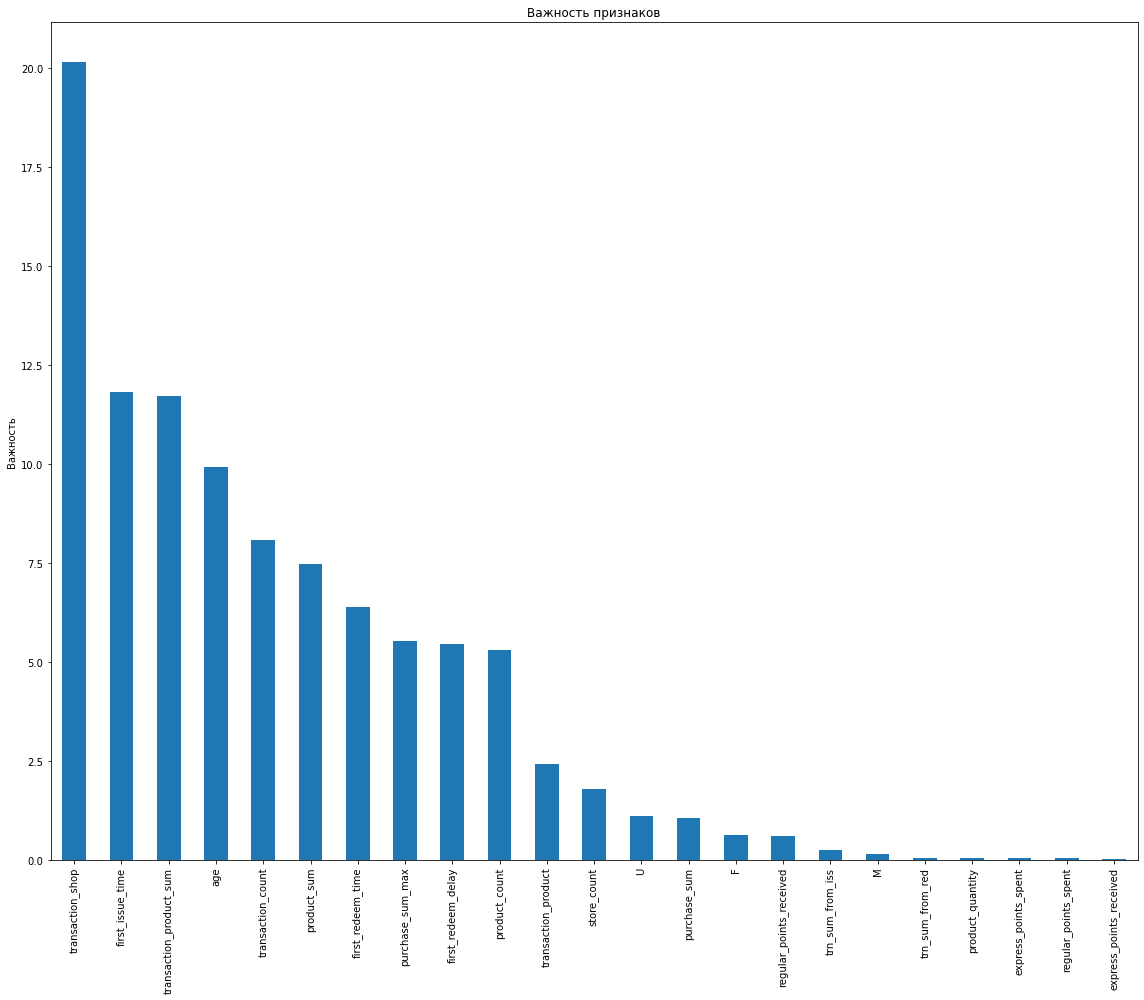

In [19]:
importance = pd.Series(model.get_feature_importance(),
                         X.columns)
importance = importance.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16,14))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

In [ ]:
# feature_drop = ['trn_sum_from_red', 'product_quantity', 'express_points_spent', 'regular_points_spent', 'express_points_received']

In [6]:
new_train_2.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,treatment_flg,purchased,age,first_issue_time,first_redeem_time,first_redeem_delay,F,M,U,transaction_count,store_count,product_count,product_sum,purchase_sum_max,transaction_shop,transaction_product,transaction_product_sum,new_target
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN,0,1,45,1501947648,1.515094e+09,13146559.0,0,0,1,4,3,46,54.0,1007.0,1.333333,11.5,13.5,0
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN,0,1,45,1501947648,1.515094e+09,13146559.0,0,0,1,4,3,46,54.0,1007.0,1.333333,11.5,13.5,0
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN,0,1,45,1501947648,1.515094e+09,13146559.0,0,0,1,4,3,46,54.0,1007.0,1.333333,11.5,13.5,0
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN,0,1,45,1501947648,1.515094e+09,13146559.0,0,0,1,4,3,46,54.0,1007.0,1.333333,11.5,13.5,0
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN,0,1,45,1501947648,1.515094e+09,13146559.0,0,0,1,4,3,46,54.0,1007.0,1.333333,11.5,13.5,0


In [29]:
model.fit(X, y)

### Предсказание test`a. Сохранение.

In [51]:
new_test_drop = new_test.drop('client_id', axis=1)
itog = model.predict_proba(new_test_drop)
itog = itog[:, 1]
df = {'client_id': new_test.client_id, 'pred': itog}
YED = pd.DataFrame(data=df)

In [56]:
YED = YED.drop_duplicates(subset=['client_id'])

In [58]:
YED.to_csv(r'C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/YED_5.csv',index=False)

### Использую sklift

In [64]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift catboost pandas

Defaulting to user installation because normal site-packages is not writeable


In [11]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import TwoModels

In [13]:
# определение переменных
X = new_train_2.drop(['purchased', 
                      'client_id', 
                      'treatment_flg', 
#                       'new_target', 
                      'transaction_id', 
                      'transaction_datetime', 
                      'store_id', 
                      'product_id'], axis=1)
y = new_train_2['purchased']
treatment = new_train_2['treatment_flg']


X_train, X_val, y_train, y_val, treatment_train, treatment_val = train_test_split(X, y, treatment, test_size=0.3, random_state=42)

In [14]:
tm_clf = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=306,
                           learning_rate=0.0016991916641317583,
                           depth=4,
                           l2_leaf_reg=0.001175380363184585,
                           bootstrap_type='Bayesian',
                           random_strength=2.7993283787565373e-07,
                           bagging_temperature=9.021784577022341,
                           od_type='Iter',
                           od_wait=44, verbose=False), 
    estimator_ctrl=CatBoostClassifier(iterations=306,
                           learning_rate=0.0016991916641317583,
                           depth=4,
                           l2_leaf_reg=0.001175380363184585,
                           bootstrap_type='Bayesian',
                           random_strength=2.7993283787565373e-07,
                           bagging_temperature=9.021784577022341,
                           od_type='Iter',
                           od_wait=44, verbose=False), 
    method='vanilla'
)

tm_clf = tm_clf.fit(
    X_train, y_train, treatment_train
)

In [15]:
uplift_tm = tm_clf.predict(X_val)
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val, strategy='by_group', k=0.3)

In [16]:
uplift_tm

array([0.01413532, 0.0054883 , 0.01073426, ..., 0.0112515 , 0.01376096,
       0.00854628])

In [17]:
tm_full = tm_clf.fit(
    X, 
    y, 
    treatment, 
)

In [77]:
new_test_drop = new_test.drop('client_id', axis=1)

In [78]:
uplift_tm_full = tm_full.predict(new_test_drop)
uplift_df = {'client_id': new_test.client_id, 'uplift': uplift_tm_full}
YED = pd.DataFrame(data=uplift_df)

In [79]:
YED = YED.groupby('client_id',as_index=False).uplift.mean()
YED = YED.sort_values('uplift', ascending=False)

In [90]:
YED = YED.assign(pred = 0)
YED['pred'].mask(YED['uplift'] >= 0.017, 1, inplace=True)

In [93]:
YED_6 = YED.drop('uplift', axis=1)

In [95]:
YED_6.to_csv(r'C:/Users/adosf/OneDrive/Рабочий стол/ЦФТ/x5-uplift-valid/data/YED_7.csv',index=False)